In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error, roc_curve,auc)
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
%matplotlib inline

In [2]:
path = './dataset/'
train_path = path + 'KDDTrain+.txt'
test_path = path + 'KDDTest+.txt'

In [3]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

In [4]:
traindata = pd.read_csv(train_path, header=None, names = col_names)
testdata = pd.read_csv(test_path, header=None, names = col_names)
print('Dimensions of the Training set:',traindata.shape)
print('Dimensions of the Test set:',testdata.shape)

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)


In [5]:
traindata.drop('difficulty_level', axis=1, inplace=True)
testdata.drop('difficulty_level', axis=1, inplace=True)

## label分布

In [6]:
label_count = traindata.label.value_counts()

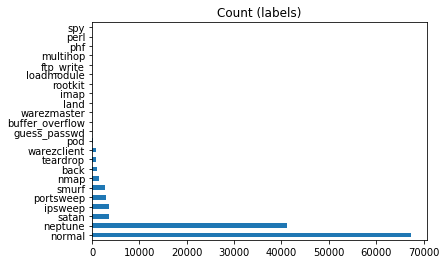

In [7]:
label_count.plot(kind='barh', title='Count (labels)')

## 特征数字化

In [8]:
prot_dict = {'tcp':0, 'udp':1, 'icmp':2}
serv_dict = {'aol':0, 'auth':1, 'bgp':2, 'courier':3, 'csnet_ns':4,'ctf':5, 'daytime':6, 'discard':7,
             'domain':8, 'domain_u':9,'echo':10, 'eco_i':11, 'ecr_i':12, 'efs':13, 'exec':14,'finger':15,
             'ftp':16, 'ftp_data':17, 'gopher':18, 'harvest':19,'hostnames':20, 'http':21, 'http_2784':22,
             'http_443':23, 'http_8001':24,'imap4':25, 'IRC':26, 'iso_tsap':27, 'klogin':28, 'kshell':29,
             'ldap':30, 'link':31, 'login':32, 'mtp':33, 'name':34,'netbios_dgm':35, 'netbios_ns':36,
             'netbios_ssn':37, 'netstat':38, 'nnsp':39,'nntp':40, 'ntp_u':41, 'other':42, 'pm_dump':43, 
             'pop_2':44,'pop_3':45, 'printer':46, 'private':47, 'red_i':48, 'remote_job':49,'rje':50, 
             'shell':51, 'smtp':52, 'sql_net':53, 'ssh':54,'sunrpc':55, 'supdup':56, 'systat':57, 
             'telnet':58, 'tftp_u':59,'tim_i':60, 'time':61, 'urh_i':62, 'urp_i':63, 'uucp':64,
             'uucp_path':65, 'vmnet':66, 'whois':67, 'X11':68, 'Z39_50':69}
# 只有SF正常
flag_dict = {'OTH':0, 'REJ':0, 'RSTO':0,'RSTOS0':0, 'RSTR':0, 'S0':0,'S1':0, 'S2':0, 'S3':0,'SF':1, 'SH':0}

In [9]:
traindata['protocol_type'] = traindata['protocol_type'].map(prot_dict)
traindata['service'] = traindata['service'].map(serv_dict)
traindata['flag'] = traindata['flag'].map(flag_dict)
testdata['protocol_type'] = testdata['protocol_type'].map(prot_dict)
testdata['service'] = testdata['service'].map(serv_dict)
testdata['flag'] = testdata['flag'].map(flag_dict)

## 类别细分类

In [10]:
attacks = traindata['label'].unique().tolist() + testdata['label'].unique().tolist()
attacks = sorted(set(attacks),key=attacks.index)
traindata['label_fine'] = traindata['label'].apply(lambda x : attacks.index(x))
testdata['label_fine'] = testdata['label'].apply(lambda x : attacks.index(x))
traindata.drop('label', axis=1, inplace=True)
testdata.drop('label', axis=1, inplace=True)

## 类别粗分类

In [11]:
NORMAL = [attacks.index('normal')]
PROBE = [attacks.index(x) for x in ['ipsweep','mscan','nmap','portsweep','saint','satan']]
DOS = [attacks.index(x) for x in ['apache2','back','land','mailbomb','neptune','pod','processtable','smurf','teardrop','udpstorm']]
U2R = [attacks.index(x) for x in ['buffer_overflow','httptunnel','loadmodule','perl','ps','rootkit','sqlattack','xterm']]
R2L = [attacks.index(x) for x in ['ftp_write','guess_passwd','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','worm','xlock','xsnoop']]

In [12]:
coarse_dic = {
    'NORMAL':0,
    'PROBE':1,
    'DOS':2,
    'U2R':3,
    'R2L':4}
def coarse_helper(x):
    if x in NORMAL:
        return coarse_dic['NORMAL']
    elif x in PROBE:
        return coarse_dic['PROBE']
    elif x in DOS:
        return coarse_dic['DOS']
    elif x in U2R:
        return coarse_dic['U2R']
    elif x in R2L:
        return coarse_dic['R2L']
traindata['label_coarse'] = traindata['label_fine'].apply(lambda x : coarse_helper(x))
testdata['label_coarse'] = testdata['label_fine'].apply(lambda x : coarse_helper(x))

In [13]:
traindata.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label_fine', 'label_coarse'],
      dtype='object')

In [14]:
traindata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label_fine,label_coarse
0,0,0,17,1,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,0
1,0,1,42,1,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0
2,0,0,47,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,2
3,0,0,21,1,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,0
4,0,0,21,1,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0


## 粗分类标签分布

In [15]:
print(testdata['label_coarse'].value_counts())

0    9711
2    7458
4    2754
1    2421
3     200
Name: label_coarse, dtype: int64


In [16]:
print(traindata['label_coarse'].value_counts().sort_values(ascending=False))

0    67343
2    45927
1    11656
4      995
3       52
Name: label_coarse, dtype: int64


In [17]:
coarse_count = traindata['label_coarse'].value_counts()

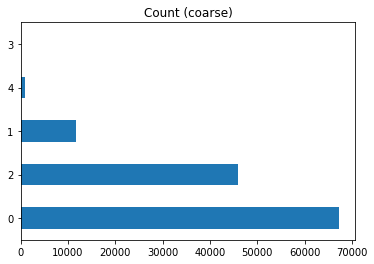

In [18]:
ax = coarse_count.plot(kind='barh', title='Count (coarse)')

## 归一化

In [19]:
scaler = MinMaxScaler()
traindata.iloc[:,0:41] = scaler.fit_transform(traindata.iloc[:,0:41])
testdata.iloc[:,0:41] = scaler.fit_transform(testdata.iloc[:,0:41])

In [20]:
traindata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label_fine,label_coarse
0,0.0,0.0,0.246377,1.0,3.558064e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,0
1,0.0,0.5,0.608696,1.0,1.057999e-07,0.000000e+00,0.0,0.0,0.0,0.0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,0
2,0.0,0.0,0.681159,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,2
3,0.0,0.0,0.304348,1.0,1.681203e-07,6.223962e-06,0.0,0.0,0.0,0.0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,0
4,0.0,0.0,0.304348,1.0,1.442067e-07,3.206260e-07,0.0,0.0,0.0,0.0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0


## 特征选择
#### 过滤方差小的

In [21]:
# from sklearn.feature_selection import VarianceThreshold
# feature_sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# newtrain = feature_sel.fit_transform(traindata)
# newtrain = pd.DataFrame(newtrain)
# newtrain.head()

## 划分训练集

In [22]:
X_train = traindata.iloc[:,0:41]
Y_train = traindata.loc[:,'label_coarse']
X_test = testdata.iloc[:,0:41]
Y_test = testdata.loc[:,'label_coarse']


## 类别不平衡 - 过采样

In [23]:
# 过采样
# from imblearn.over_sampling import SMOTE
# X_train, Y_train = SMOTE().fit_sample(X_train, Y_train)
# from collections import Counter
# print(sorted(Counter(Y_train).items()))


## TSNE 高维数据可视化

In [24]:
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt

tsne = TSNE(n_components=3, init='pca', n_iter=5000)
X_tsne = tsne.fit_transform(X_test[:500])

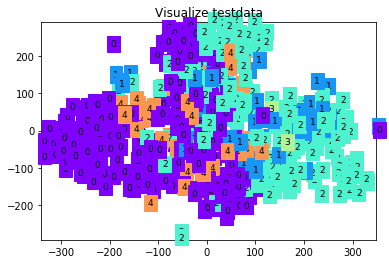

In [25]:
# x1轴，x2轴
x1, x2 = X_tsne[:, 0], X_tsne[:, 1]

for x, y, s in zip(x1, x2, Y_test[:500]):
    # 把0-255颜色区间分为5份,然后把标签映射到一个区间
    c = cm.rainbow(int(255/5 * s)) 
    plt.text(x, y, s, backgroundcolor=c, fontsize=9)
# plt.scatter(x1, x2, Y_test[:500])
    
plt.xlim(x1.min(), x1.max())
plt.ylim(x2.min(), x2.max())
plt.title('Visualize testdata')
plt.show()

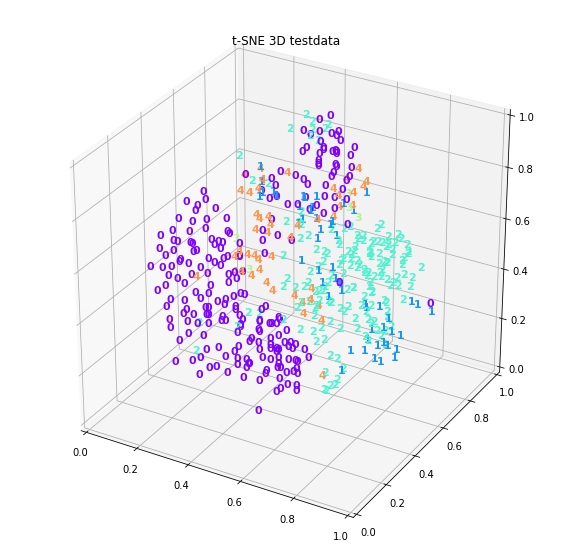

In [26]:
def plot_embedding_3d(X, labels, title=None):
    # 归一化
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    for i in range(X.shape[0]):
        c = cm.rainbow(int(255/5 * labels[i]))
        ax.text(x[i], y[i], z[i], str(labels[i]), color=c, fontdict={'weight': 'bold', 'size': 11})
    plt.title(title)
    plt.show()

import time
from mpl_toolkits.mplot3d import Axes3D
plot_embedding_3d(X_tsne,Y_test[:500],"t-SNE 3D testdata")

## 类别不平衡 - 增加类别/样本权重

In [27]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',
                                                 np.unique(Y_train),
                                                 Y_train)
class_weight = dict(enumerate(class_weight))
print(class_weight)

{0: 0.3741235169208381, 1: 2.1615133836650653, 2: 0.5485792670977856, 3: 484.51153846153846, 4: 25.321206030150755}


G:\Anaconda\anaconda\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[0 1 2 3 4], y=0         0
1         0
2         2
3         0
4         0
5         2
6         2
7         2
8         2
9         2
10        2
11        2
12        0
13        4
14        2
15        2
16        0
17        1
18        0
19        0
20        2
21        2
22        0
23        0
24        2
25        0
26        2
27        0
28        0
29        0
         ..
125943    0
125944    0
125945    0
125946    2
125947    1
125948    2
125949    0
125950    2
125951    0
125952    0
125953    2
125954    0
125955    0
125956    0
125957    0
125958    2
125959    0
125960    0
125961    0
125962    0
125963    0
125964    2
125965    0
125966    2
125967    0
125968    2
125969    0
125970    0
125971    2
125972    0
Name: label_coarse, Length: 125973, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  Future

In [28]:
class_weight

{0: 0.3741235169208381,
 1: 2.1615133836650653,
 2: 0.5485792670977856,
 3: 484.51153846153846,
 4: 25.321206030150755}

## 拓展维度

In [29]:
train_x = np.reshape(np.array(X_train), (np.array(X_train).shape[0],np.array(X_train).shape[1],1))
test_x = np.reshape(np.array(X_test), (np.array(X_test).shape[0],np.array(X_test).shape[1],1))

## CNN-LSTM
### <font color=Red>3个特征列onehot与否，都存在样本分布不均匀导致的小样本预测差问题</font>

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Convolution1D,MaxPooling1D, Flatten,LSTM

In [31]:
model = Sequential()
model.add(Convolution1D(64, 3, padding="same",activation="relu",input_shape=(41, 1)))
model.add(MaxPooling1D(2))
model.add(LSTM(526))
model.add(Dropout(0.1))
model.add(Dense(5, activation="softmax"))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 41, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 526)               1243464   
_________________________________________________________________
dropout (Dropout)            (None, 526)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2635      
Total params: 1,246,355
Trainable params: 1,246,355
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(train_x,Y_train,
                       epochs = 10,
                       batch_size=1000,
                    class_weight = class_weight,
                       validation_split=0.1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 113375 samples, validate on 12598 samples
Epoch 1/10
113375/113375 [==============================] - 37s 323us/sample - loss: 1.2465 - accuracy: 0.5195 - val_loss: 0.8307 - val_accuracy: 0.8905
Epoch 2/10
113375/113375 [==============================] - 35s 312us/sample - loss: 0.7004 - accuracy: 0.8286 - val_loss: 0.5227 - val_accuracy: 0.8570
Epoch 3/10
113375/113375 [==============================] - 36s 320us/sample - loss: 0.5468 - accuracy: 0.8553 - val_loss: 0.4914 - val_accuracy: 0.8806
Epoch 4/10
113375/113375 [==============================] - 38s 335us/sample - loss: 0.4875 - accuracy: 0.8683 - val_loss: 0.5381 - val_accuracy: 0.9186
Epoch 5/10
113375/113375 [==============================] - 39s 341us/sample - loss: 0.4935 - accuracy: 0.8682 - val_loss: 0.5972 - val_accuracy: 0.8689
Epoch 6/10
113375/113375 [==============================] - 39s 344us/sample - loss: 0.4363 - accuracy: 0.8761 - val_loss: 0.4821 - va

In [33]:
model.save('./save/CNN-LSTM2.h5')

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

def show_history(history):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.plot(history.history['accuracy'], c='b', label='train')
    plt.plot(history.history['val_accuracy'], c='g', label='validation')
    plt.legend()
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(.02))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Model accuracy')

    plt.subplot(122)
    plt.plot(history.history['loss'], c='b', label='train')
    plt.plot(history.history['val_loss'], c='g', label='validation')
    plt.legend()
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(.05))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Model loss')

    plt.show()

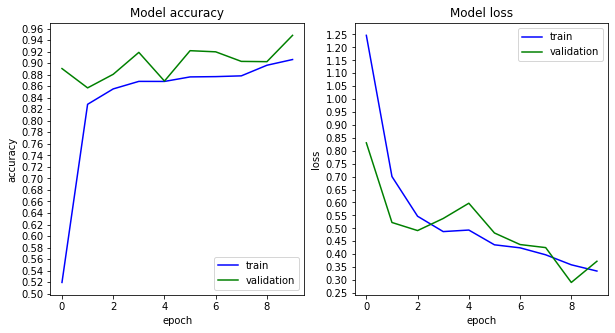

In [35]:
show_history(history)

In [36]:
pre = model.predict(test_x)
pre = np.argmax(pre, axis=1)
print(classification_report(Y_test, pre))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      9711
           1       0.58      0.58      0.58      2421
           2       0.94      0.71      0.81      7458
           3       0.50      0.14      0.22       200
           4       0.89      0.32      0.47      2754

    accuracy                           0.75     22544
   macro avg       0.72      0.54      0.58     22544
weighted avg       0.78      0.75      0.73     22544

